# Testing workflow to get xarray dataset into Geoscience Analyst // geoh5py

motovation for this is verde and harmonica both use xarray. Looking on best practices for I/O from xarray to geoh5py. This notebook was made in response to issue #97 on github [(here)](https://github.com/MiraGeoscience/geoh5py/issues/97). 

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

Dataset made with [verde](https://pypi.org/project/verde/)  and [xarray](http://xarray.pydata.org/en/stable/). 

In [2]:
grid_name = "grid_save_out" # open source radiometric data from BC
dataset = xr.open_dataset(f'{grid_name}.nc')

In [3]:
dataset

<xarray.Dataset>
Dimensions:   (utm_x: 300, utm_y: 387)
Coordinates:
  * utm_x     (utm_x) float64 6.109e+05 6.111e+05 ... 6.704e+05 6.706e+05
  * utm_y     (utm_y) float64 6.271e+06 6.271e+06 ... 6.348e+06 6.348e+06
Data variables:
    k         (utm_y, utm_x) float64 ...
    masked_k  (utm_y, utm_x) float64 ...
Attributes:
    metadata:  Generated by ScipyGridder()

Quick plot of the radiometric data:

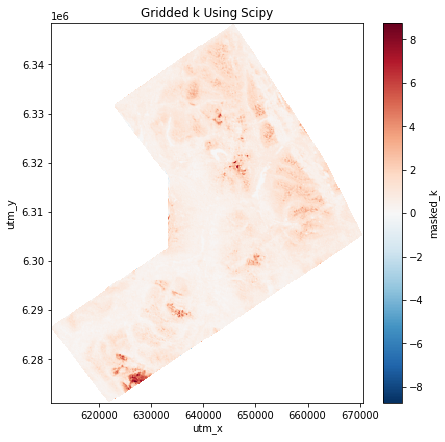

In [4]:
plt.figure(figsize=(7, 7))

pc = dataset.masked_k.plot.pcolormesh(add_colorbar=True)
plt.title("Gridded k Using Scipy")
plt.show()

## Let's test out geoh5py

In [5]:
# uncomment next line if you need to install the package
# !pip install geoh5py --upgrade

In [6]:
import geoh5py
geoh5py.__version__

'0.1.2'

In [7]:
import geoh5py
print("geoh5py ver:", geoh5py.__version__)

from geoh5py.workspace import Workspace
from geoh5py.objects import Grid2D

# Create a new project
workspace = Workspace("my_project.geoh5")

geoh5py ver: 0.1.2


In [8]:
workspace.objects

[]

In [9]:
dataset

<xarray.Dataset>
Dimensions:   (utm_x: 300, utm_y: 387)
Coordinates:
  * utm_x     (utm_x) float64 6.109e+05 6.111e+05 ... 6.704e+05 6.706e+05
  * utm_y     (utm_y) float64 6.271e+06 6.271e+06 ... 6.348e+06 6.348e+06
Data variables:
    k         (utm_y, utm_x) float64 ...
    masked_k  (utm_y, utm_x) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    metadata:  Generated by ScipyGridder()

Let's make some off the cuff calculations

In [10]:
#might be a better way to do some of these steps ...
x_step = dataset.utm_x[2]-dataset.utm_x[1] 
y_step = dataset.utm_y[2]-dataset.utm_y[1]

origin_x = dataset.utm_x.min()
origin_y = dataset.utm_y.min()

count_x = dataset.utm_x.size
count_y = dataset.utm_y.size

Next cell is just for some QC:

In [11]:
print("x step", x_step);
print("origin_x", origin_x);
print("count_x", count_x);

dataset.masked_k.values

x step <xarray.DataArray 'utm_x' ()>
array(199.83444816)
origin_x <xarray.DataArray 'utm_x' ()>
array(610874.3)
count_x 300


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

Example from the [documentation](https://geoh5py.readthedocs.io/en/latest/content/user_guide/entities.html#Grid2D).

In [12]:
grid = Grid2D.create(
    workspace,
    name=grid_name,
    origin = [origin_x, origin_y, 0], #needs to have a z
    u_cell_size = float(x_step),
    v_cell_size = float(y_step),
    u_count = count_x,
    v_count = count_y,
    #rotation = 90.0,
    #dip = 45.0,
)

Addding the data

In [13]:
grid.add_data({
    "masked_k": {"values": dataset.masked_k.values.flatten()}
})

## Let's try to pull out the data, and make it into xarray.

In [14]:
def object_2_dataframe(entity, fields=[], inplace=False, vertices=True, index=None):
    """
    Convert an object to a pandas dataframe
    """
    if getattr(entity, "vertices", None) is not None:
        locs = entity.vertices
    elif getattr(entity, "centroids", None) is not None:
        locs = entity.centroids

    if index is None:
        index = np.arange(locs.shape[0])

    data_dict = {}
    if vertices:
        data_dict["X"] = locs[index, 0]
        data_dict["Y"] = locs[index, 1]
        data_dict["Z"] = locs[index, 2]

    d_f = pd.DataFrame(data_dict, columns=list(data_dict.keys()))
    for field in fields:
        if entity.get_data(field):
            obj = entity.get_data(field)[0]
            if obj.values.shape[0] == locs.shape[0]:
                d_f[field] = obj.values.copy()[index]
                if inplace:
                    obj.values = None

    return d_f

## Let's get the data in there

In [15]:
test = object_2_dataframe(grid, fields=["masked_k"])
test

,X,Y,Z,masked_k
0,610974.217224,6.271213e+06,0.0,NaN
1,611174.051672,6.271213e+06,0.0,NaN
2,611373.886120,6.271213e+06,0.0,NaN
3,611573.720569,6.271213e+06,0.0,NaN
4,611773.555017,6.271213e+06,0.0,NaN
...,...,...,...,...
116095,669925.379431,6.348449e+06,0.0,NaN
116096,670125.213880,6.348449e+06,0.0,NaN
116097,670325.048328,6.348449e+06,0.0,NaN
116098,670524.882776,6.348449e+06,0.0,NaN


In [16]:
x = test.X.values
y = test.Y.values
z = test.Z.values


In [17]:
idx = pd.MultiIndex.from_arrays(arrays=[x,y], names=["utm_x","utm_y"])

In [18]:
s = pd.Series(data=test.masked_k, index=idx)
s

utm_x          utm_y       
610974.217224  6.271213e+06   NaN
611174.051672  6.271213e+06   NaN
611373.886120  6.271213e+06   NaN
611573.720569  6.271213e+06   NaN
611773.555017  6.271213e+06   NaN
                               ..
669925.379431  6.348449e+06   NaN
670125.213880  6.348449e+06   NaN
670325.048328  6.348449e+06   NaN
670524.882776  6.348449e+06   NaN
670724.717224  6.348449e+06   NaN
Name: masked_k, Length: 116100, dtype: float64

In [19]:
da = xr.DataArray.from_series(s)
da = da.to_dataset()
da

<xarray.Dataset>
Dimensions:   (utm_x: 300, utm_y: 387)
Coordinates:
  * utm_x     (utm_x) float64 6.11e+05 6.112e+05 ... 6.705e+05 6.707e+05
  * utm_y     (utm_y) float64 6.271e+06 6.271e+06 ... 6.348e+06 6.348e+06
Data variables:
    masked_k  (utm_x, utm_y) float64 nan nan nan nan nan ... nan nan nan nan nan

### fin!